<a href="https://colab.research.google.com/github/SarahSaeedKhan/DTI/blob/main/MIC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code has been modified. The old/original version works with torch==1.6.0..  Please install torch==1.6.0 on local PC to use the old version of the code.

In [ ]:
!git clone https://github.com/Utkarsh0203/CS-MRI-Reconstruction-using-GAN-with-cyclic-loss.git

Cloning into 'CS-MRI-Reconstruction-using-GAN-with-cyclic-loss'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (481/481), done.
remote: Compressing objects: 100% (477/477), done.
remote: Total 481 (delta 16), reused 453 (delta 3), pack-reused 0
Receiving objects: 100% (481/481), 45.38 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,utils,datasets
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from IPython.display import clear_output

In [ ]:
assert torch.cuda.is_available()

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
batch_size = 10

In [ ]:
MASK = 'radial'
MASK_PERCENT = '20'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])

This code has been modified. Please install torch==1.6.0 on local PC to use the old version of the code. Only `torch.fft` to `torch.fft.fft()`. Same for the `torch.ifft` to `torch.fft.ifft()`

!pip install torch==1.6.0 torchvision==0.7.0

In [ ]:
def RF(image, mask, batch = False):	#both image and mask arg are (2,256,256) tensors
  if not batch:
    image = image.permute(1,2,0)
    mask = mask.permute(1,2,0)
    frq = torch.fft.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(2,0,1)
    return res.real
  else:
    image = image.permute(0,2,3,1)
    mask = mask.permute(0,2,3,1)
    frq = torch.fft.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(0,3,1,2)
    return res.real

def FhRh(frq, batch = False):
  if not batch:
    frq = frq.permute(1,2,0)
    res = torch.fft.ifft(frq, 2) #Modified this code for newer version
    res = torch.clamp(res.real, min=-1, max=1)
    res = res.permute(2,0,1)
    return res.real
  else:
    frq = frq.permute(0,2,3,1)
    res = torch.fft.ifft(frq, 2) #Modified this code for newer version
    res = torch.clamp(res.real, min=-1, max=1)
    res = res.permute(0,3,1,2)
    return res.real

def displayTensor(tnsr, name="image"):	#input tensor is (2,256,256)
  real = tnsr[0]
  image = (real+1)*255/2
  image = np.array(image, dtype="uint8")
  plt.imshow(image, cmap='gray', vmin=0, vmax=255)
  # cv2.imshow(name, image)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [ ]:
class Dataset_train(Dataset):
	def __init__(self, data_dir='/content/CS-MRI-Reconstruction-using-GAN-with-cyclic-loss/data/brain/db_train',
	             mask_path='/content/CS-MRI-Reconstruction-using-GAN-with-cyclic-loss/data/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PERCENT),
						   transform=train_transforms):
		self.us_train_data = []
		self.transform=transform
		self.mask = cv2.imread(mask_path)
		self.mask = cv2.cvtColor(self.mask, cv2.COLOR_BGR2GRAY)/255
		self.mask2 = torch.zeros(2,256,256)
		self.mask2[0] = torch.Tensor(self.mask)
		self.mask2[1] = torch.Tensor(self.mask)
		i=0
		for filename in os.listdir(data_dir):
			image = Image.open('{}/{}'.format(data_dir, filename))
			# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			# image = 2*(image/255) - 1
			self.us_train_data.append(image)
			i = i+1

	def __len__(self):
		return len(self.us_train_data)

	def __getitem__(self, idx):
		sample = self.us_train_data[idx]
		sample2 = (self.transform(sample))*2-1
		image = torch.zeros(2,256,256)
		image[0] = sample2
		image[1] = image[1]-1
		# self.us_train_data[idx,0] = (self.transform(sample))*2-1
		# sample = sample*2 -1
		# image = self.us_train_data[idx]
		frq = RF(image, self.mask2)
		res = FhRh(frq)
		fin = tuple([image,frq,res])
		return fin

In [ ]:
train_data = Dataset_train()
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
fre1 = train_data[0][2]
print(torch.min(fre1),torch.max(fre1))

tensor(-1.) tensor(0.6235)


In [ ]:
class ResidualCell(nn.Module):
  def __init__(self, n_filters):
    super(ResidualCell, self).__init__()
    #Residual connections, (H,W) remain same
    self.conv_i = nn.Conv2d(n_filters, n_filters, (3,3), 1, 1) #Why is this layer needed?
    self.conv_m = nn.Conv2d(n_filters, int(n_filters/2), (3,3), 1, 1)
    self.conv_o = nn.Conv2d(int(n_filters/2), n_filters, (3,3), 1, 1)

    self.res_net = nn.Sequential(self.conv_i, nn.BatchNorm2d(n_filters), nn.ReLU(),
                                 self.conv_m, nn.BatchNorm2d(int(n_filters/2)), nn.ReLU(),
                                 self.conv_o, nn.BatchNorm2d(n_filters), nn.ReLU())

  def forward(self, x):
    return x+self.res_net(x)

In [ ]:
class EncoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0, leaky = False):
    super(EncoderCell, self).__init__()

    self.conv_a = nn.Conv2d(n_in, n_res, (3,3), 2, padding=pad)
    self.res = ResidualCell(n_res)
    self.conv_b = nn.Conv2d(n_res, n_res, (3,3), 1)

    if not leaky:
      self.encoder = nn.Sequential(self.conv_a,  nn.BatchNorm2d(n_res), nn.ReLU(),
                                   self.res,
                                   self.conv_b,  nn.BatchNorm2d(n_res), nn.ReLU())
    else:
      self.encoder = nn.Sequential(self.conv_a,  nn.BatchNorm2d(n_res), nn.LeakyReLU(0.2),
                                   self.res,
                                   self.conv_b,  nn.BatchNorm2d(n_res), nn.LeakyReLU(0.2))

  def forward(self, x):
    return self.encoder(x)

In [ ]:
class DecoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0):
    super(DecoderCell, self).__init__()

    self.deconv_a = nn.ConvTranspose2d(n_in, n_res, (3,3), 1)
    self.res = ResidualCell(n_res)
    self.deconv_b = nn.ConvTranspose2d(n_res, n_res, (3,3), 2, output_padding=pad)

    self.decoder = nn.Sequential(self.deconv_a, nn.BatchNorm2d(n_res), nn.ReLU(),
                                 self.res,
                                 self.deconv_b, nn.BatchNorm2d(n_res), nn.ReLU())

  def forward(self, x):
    return self.decoder(x)

In [ ]:
class SubGenerator(nn.Module):
  """
  Input: Zero filling imperfect reconstruction by inverse of undersampled fourier transform
  Output: Full image which (should) belongs to the set of all possible perfect reconstructions
  """
  def __init__(self, n):
    super(SubGenerator, self).__init__()
    #Input channels = 2

    #ConvEncoder
    self.ec0 = EncoderCell(2,n)
    self.ec1 = EncoderCell(n,2*n)
    self.ec2 = EncoderCell(2*n,4*n)
    self.ec3 = EncoderCell(4*n,8*n)

    #ConvDecoder
    self.dc3 = DecoderCell(8*n,4*n)
    self.dc2 = DecoderCell(4*n,2*n,1)
    self.dc1 = DecoderCell(2*n,n)
    self.dc0 = DecoderCell(n,n,1)

    #Output
    self.out = nn.Sequential(nn.Conv2d(n,2,(3,3),1,1), #Real and Complex channels as outputs?
                             nn.Tanh())

  def forward(self, x):
    #With Residual Connections
    # print(x.shape)
    e0 = self.ec0(x)
    # print(e0.shape)
    e1 = self.ec1(e0)
    # print(e1.shape)
    e2 = self.ec2(e1)
    # print(e2.shape)
    e3 = self.ec3(e2)
    # print(e3.shape)

    d3 = self.dc3(e3)
    # print(d3.shape)
    d2 = self.dc2(d3+e2)
    # print(d2.shape)
    d1 = self.dc1(d2+e1)
    # print(d1.shape)
    d0 = self.dc0(d1+e0)
    # print(d0.shape)

    y = self.out(d0)
    # print(y.shape)

    return y


In [ ]:
class Generator(nn.Module):
  def __init__(self, n):
    super(Generator, self).__init__()

    self.reconGAN = SubGenerator(n)
    self.refineGAN = SubGenerator(n)

  def forward(self, x):
    y = x+self.reconGAN(x)
    z = y+self.refineGAN(y)
    return (y,z)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n):
    super(Discriminator, self).__init__()

    #Downsample Layers

    self.ec0 = EncoderCell(2,n,leaky=True)
    self.ec1 = EncoderCell(n,2*n,leaky=True)
    self.ec2 = EncoderCell(2*n,4*n,leaky=True)
    self.ec3 = EncoderCell(4*n,8*n,leaky=True)

    #Probability Output
    self.downsampler = nn.Sequential(self.ec0, self.ec1, self.ec2, self.ec3)
    #Abstract latent space size in final layer?
    # self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1), nn.Sigmoid()) #With BCELoss (not numerically stable)
    self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1)) #With stable bceloss with logits

  def forward(self, x):
    d = self.downsampler(x)
    y = self.out(d)
    # return torch.squeeze(y)
    return y

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# epochs = 100
epochs = 10
# batch_size = 100
num_filters = 64
lr = 0.00001

criterion_D = nn.BCEWithLogitsLoss()
criterionG_image = nn.MSELoss()
criterionG_freq = nn.MSELoss()

real_label = 1
fake_label = 0

alpha = 1.0
gamma = 10.0

netG = Generator(num_filters)
netD = Discriminator(num_filters)

opt_D = optim.Adam(netD.parameters(), lr=lr)
opt_G = optim.Adam(netG.parameters(), lr=lr)

cuda


In [ ]:
batch_mask = train_data.mask2.repeat(batch_size,1,1,1)
batch_mask = batch_mask.to(device)
# mask.shape

In [ ]:
# print(netG)

In [ ]:
# print(netD)

In [ ]:
G_parameters = filter(lambda p: p.requires_grad, netG.parameters())
Gparams = sum([np.prod(p.size()) for p in G_parameters])
print("Generator Parameters:",Gparams)
D_parameters = filter(lambda p: p.requires_grad, netD.parameters())
Dparams = sum([np.prod(p.size()) for p in D_parameters])
print("Discriminator Parameters:",Dparams)

Generator Parameters: 29977924
Discriminator Parameters: 11024673


In [ ]:
Generated_Images = []
G_loss_img = []
G_loss_freq = []
G_loss_adv = []
G_loss_total = []

G_loss_img_epoch = []
G_loss_freq_epoch = []
G_loss_adv_epoch = []
G_loss_total_epoch = []

D_loss_real = []
D_loss_fake = []
D_loss_total = []

netD.apply(weights_init)
netD.to(device)
netD.train()

netG.apply(weights_init)
netG.to(device)
netG.train()

Generator(
  (reconGAN): SubGenerator(
    (ec0): EncoderCell(
      (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (res): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

Training:<br>
We will train the D and G in an alternating fashion. <br>



G_loss_adv_epoch: 70.53 G_loss_img_epoch: 72.76 G_loss_freq_epoch: 0.63


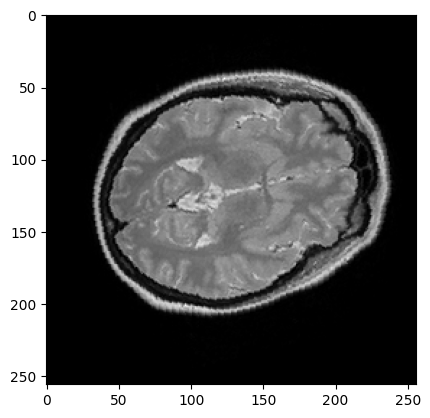

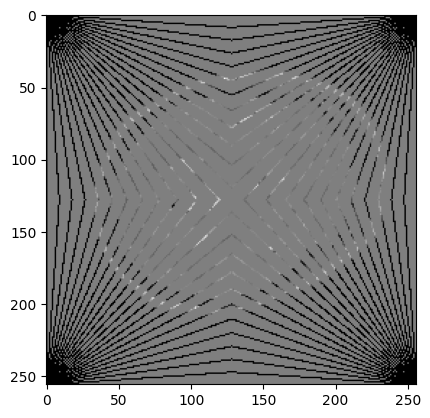

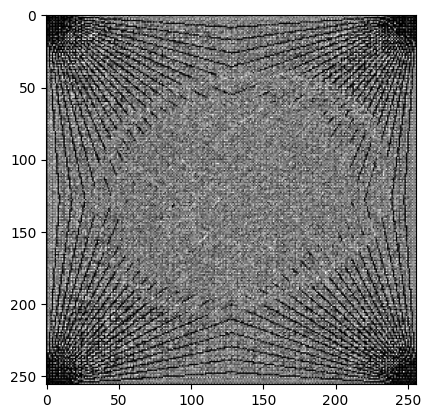

G_loss_adv_epoch: 102.96 G_loss_img_epoch: 71.82 G_loss_freq_epoch: 0.62


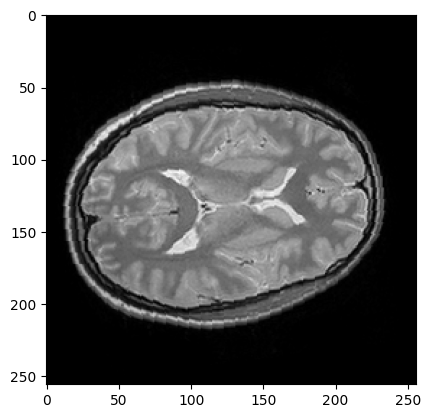

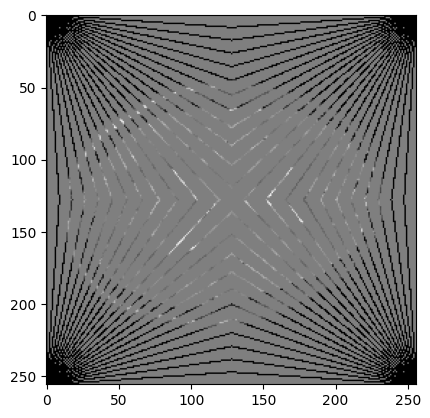

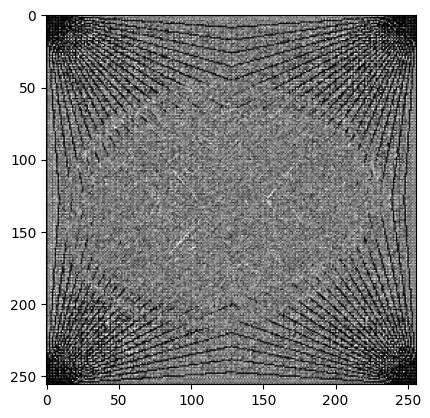

G_loss_adv_epoch: 103.95 G_loss_img_epoch: 70.82 G_loss_freq_epoch: 0.62


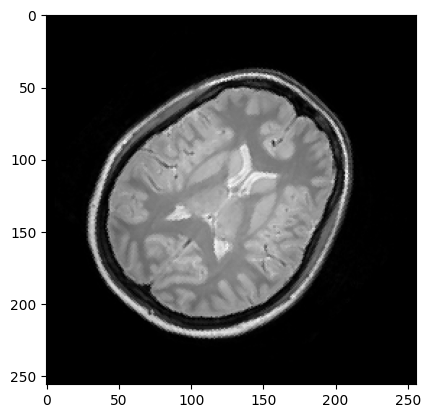

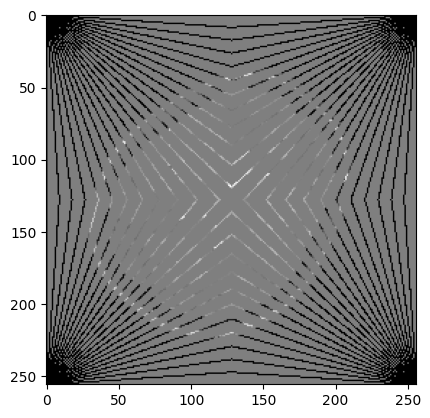

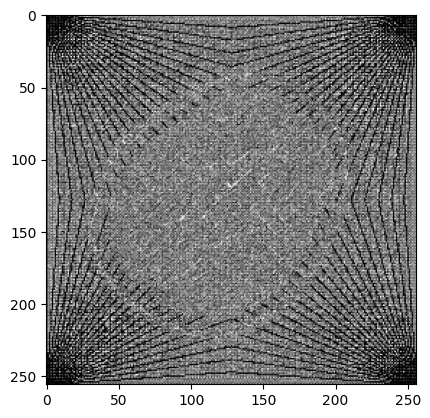

G_loss_adv_epoch: 105.93 G_loss_img_epoch: 69.89 G_loss_freq_epoch: 0.62


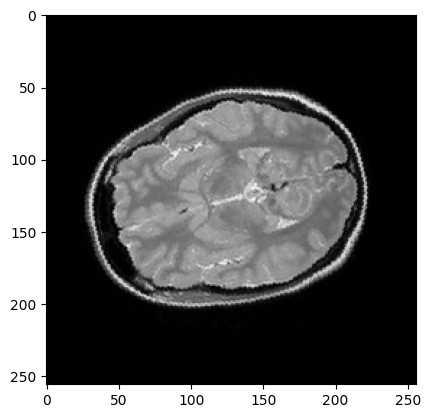

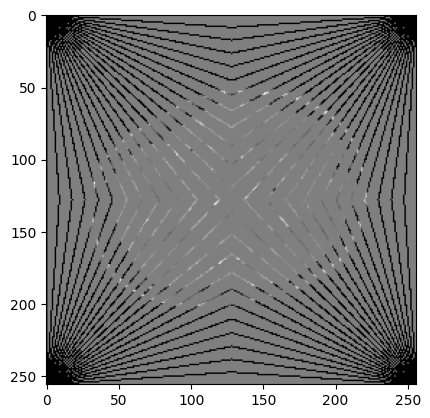

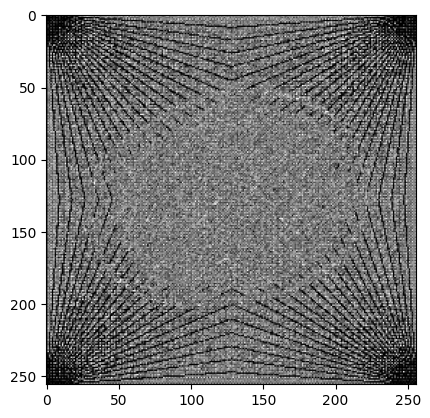

G_loss_adv_epoch: 103.25 G_loss_img_epoch: 68.97 G_loss_freq_epoch: 0.61


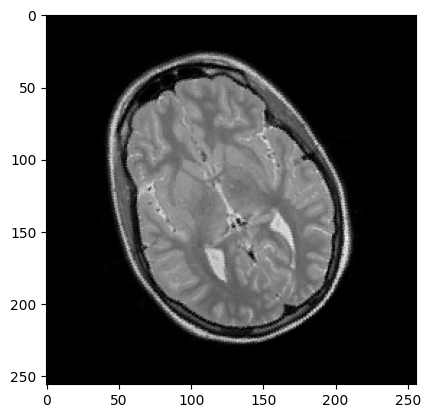

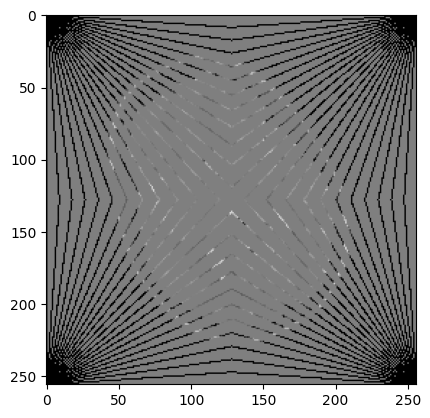

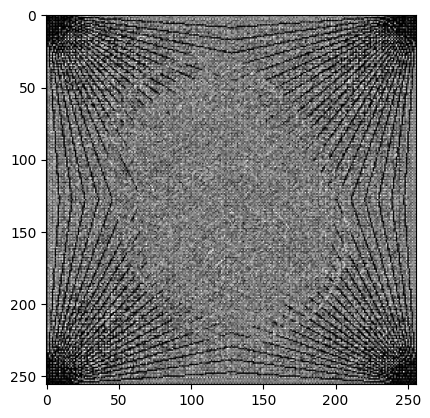

G_loss_adv_epoch: 103.07 G_loss_img_epoch: 68.14 G_loss_freq_epoch: 0.61


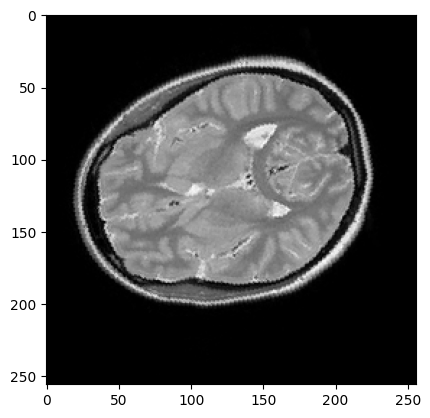

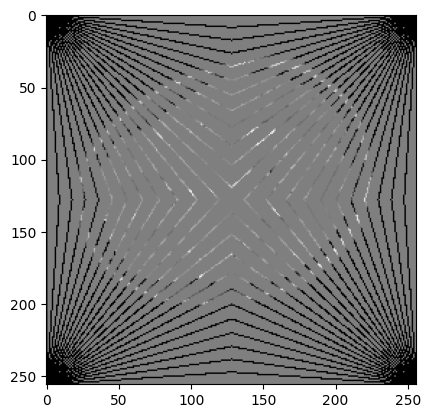

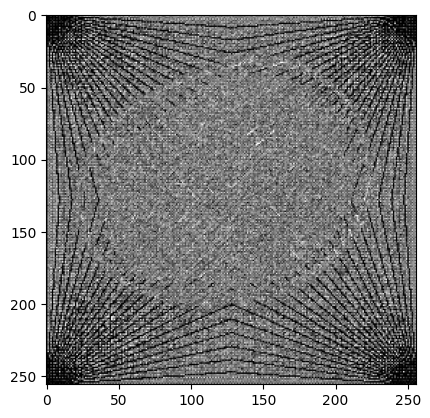

G_loss_adv_epoch: 97.59 G_loss_img_epoch: 67.29 G_loss_freq_epoch: 0.61


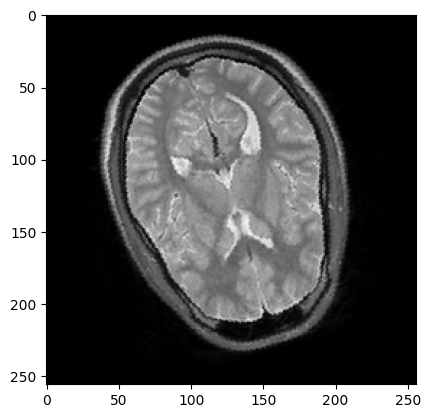

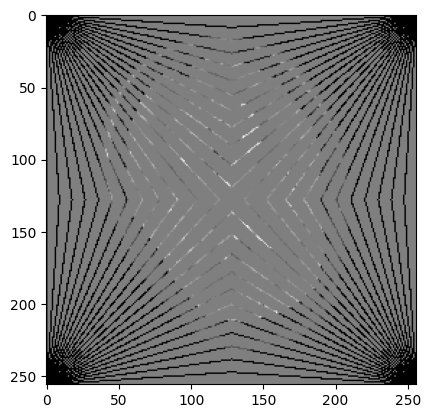

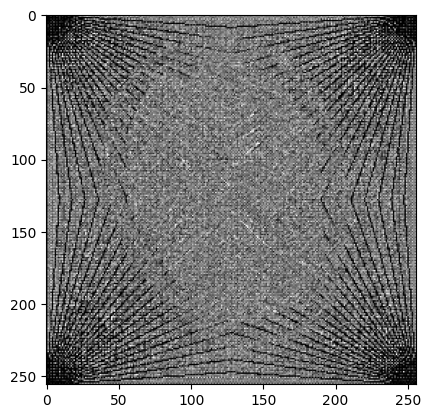

G_loss_adv_epoch: 93.43 G_loss_img_epoch: 66.46 G_loss_freq_epoch: 0.61


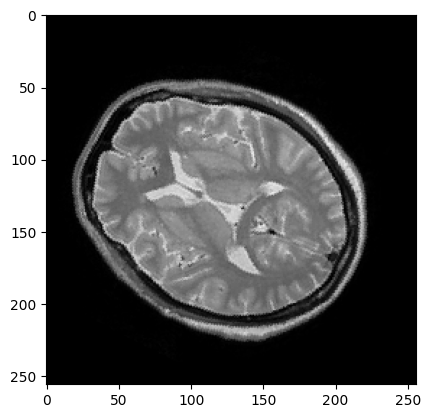

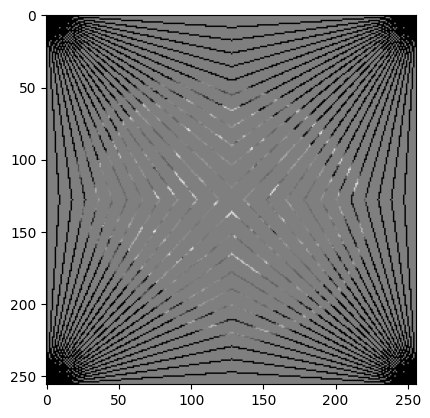

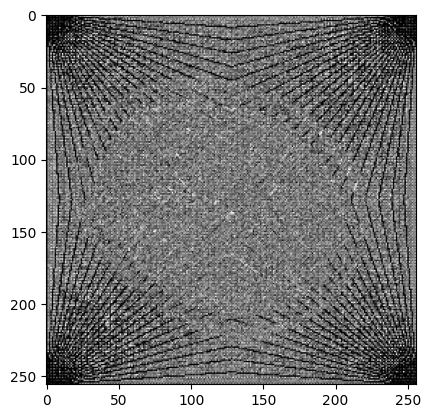

G_loss_adv_epoch: 94.59 G_loss_img_epoch: 65.65 G_loss_freq_epoch: 0.6


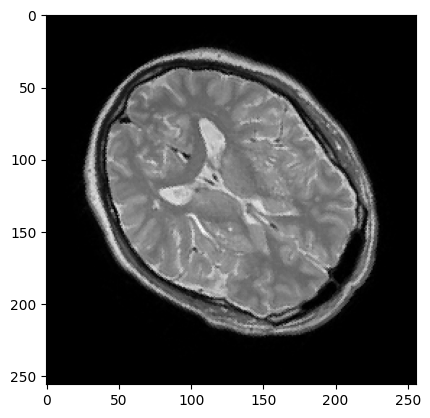

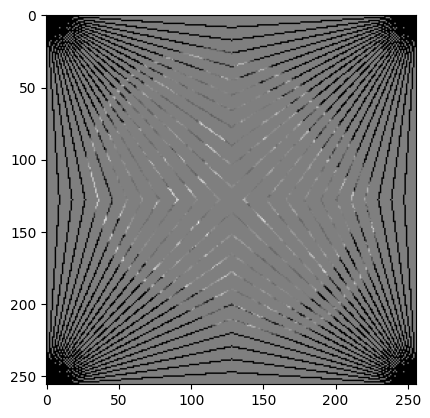

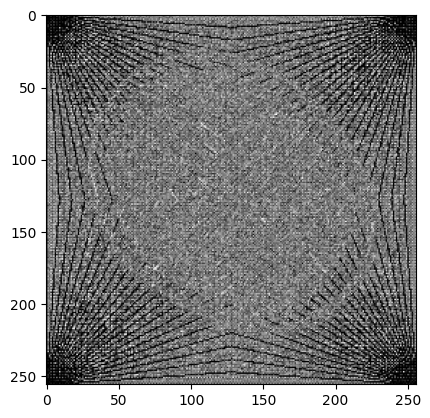

G_loss_adv_epoch: 98.02 G_loss_img_epoch: 64.77 G_loss_freq_epoch: 0.61


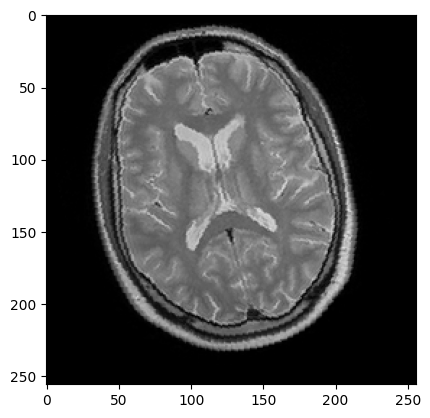

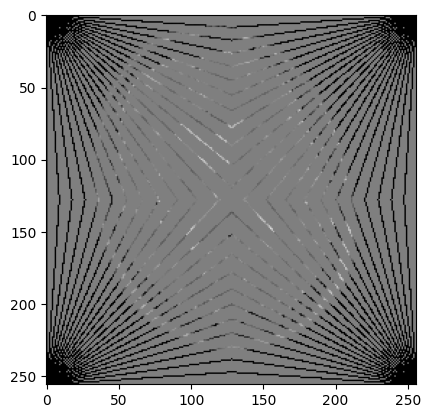

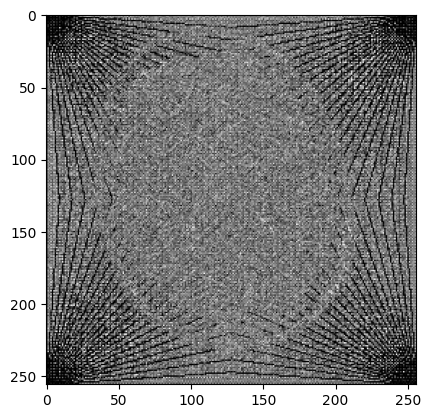

In [ ]:
# def GANvtrain(netG, netD, model_params, hyper_params criterions, optimizers, dataloader)
image_recon=[]
loss_arr=[]

for epoch in range(epochs):
  for batch_idx, im_tuple in enumerate(dataloader, 0):

    full_image_batch = im_tuple[0].to(device)
    us_kspace_batch = im_tuple[1].to(device)
    zf_recon_batch = im_tuple[2].to(device)


    # recon_image_batch = netG(torch.ifft(mask*torch.fft(full_image_batch.permute([0,2,3,1]),2)).permute([0,3,1,2]))[1]
    # recon_kspace_batch = (mask*torch.fft(netG(torch.ifft(us_kspace_batch.permute([0,2,3,1]),2).permute([0,3,1,2]))[1].permute([0,2,3,1]),2)).permute([0,3,1,2])
    # recon_image_batch = netG(FhRh(RF(full_image_batch, batch_mask, batch = True), batch = True))[0]
    # recon_kspace_batch = RF(netG(FhRh(us_kspace_batch, batch=True))[0], batch_mask, batch = True)


    #Discriminator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)

    opt_D.zero_grad()#Different mini batches for real and fake targets

    real_logits = netD(full_image_batch).view(-1)
    real_d_loss = criterion_D(real_logits, torch.full([batch_size], real_label, dtype=torch.float, device=device))
    D_loss_real.append(real_d_loss)
    real_d_loss.backward()

    gen_full_image_batch = netG(zf_recon_batch)[1]
    fake_logitsD = netD(gen_full_image_batch.detach()).view(-1)
    fake_d_loss = criterion_D(fake_logitsD, torch.full([batch_size], fake_label, dtype=torch.float, device=device))
    D_loss_fake.append(fake_d_loss)
    fake_d_loss.backward()

    # with torch.no_grad():
    d_loss_total = real_d_loss+fake_d_loss
    D_loss_total.append(d_loss_total.data)

    opt_D.step()

    #Generator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_G.zero_grad()

    fake_logitsG = netD(gen_full_image_batch).view(-1)
    adv_g_loss = criterion_D(fake_logitsG, torch.full([batch_size], real_label, dtype=torch.float, device=device))
    G_loss_adv.append(adv_g_loss)
    adv_g_loss.backward()

    recon_image_batch = netG(zf_recon_batch)[1] #Because same underlying image
    g_image_loss = gamma*criterionG_image(recon_image_batch,full_image_batch)
    G_loss_img.append(g_image_loss)
    g_image_loss.backward()

    recon_kspace_batch = RF(netG(zf_recon_batch)[1], batch_mask, batch = True) #Because same underlying image
    g_freq_loss = alpha*criterionG_freq(recon_kspace_batch,us_kspace_batch)
    G_loss_freq.append(g_freq_loss)
    g_freq_loss.backward()

    # with torch.no_grad():
    g_loss_total = adv_g_loss+g_image_loss#+g_freq_loss
    G_loss_total.append(g_loss_total)

    opt_G.step()

  # print("Epoch:", epoch, "G Loss:", float('%.2f' % g_loss_total.data.tolist()), "D Loss:", float('%.2f' % d_loss_total.data.tolist()))

  # if epoch%25==0:
  #   clear_output(wait=True)
  G_loss_adv_epoch = sum(G_loss_adv[-batch_size:])
  G_loss_img_epoch = sum(G_loss_img[-batch_size:])
  G_loss_freq_epoch = sum(G_loss_freq[-batch_size:])
  print("G_loss_adv_epoch:", float('%.2f' % G_loss_adv_epoch.data.tolist()), "G_loss_img_epoch:", float('%.2f' % G_loss_img_epoch.data.tolist()), "G_loss_freq_epoch:", float('%.2f' % G_loss_freq_epoch.data.tolist()))

  if epoch%5>=0:
    disp_img = recon_image_batch[0].cpu().detach().numpy()
    disp_img = np.clip(disp_img, -1, 1)
    disp_img2 = full_image_batch[0].cpu().detach().numpy()
    disp_img3 = zf_recon_batch[0].cpu().detach().numpy()

    displayTensor(disp_img2)
    plt.show()
    displayTensor(disp_img3)
    plt.show()
    displayTensor(disp_img)
    plt.show()
    # print(recon_image_batch.size())

  image_recon.append(disp_img)
  # loss_arr.append(g_image_loss)


cuda
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 2.8 G_loss_img_epoch: 63.98 G_loss_freq_epoch: 0.82


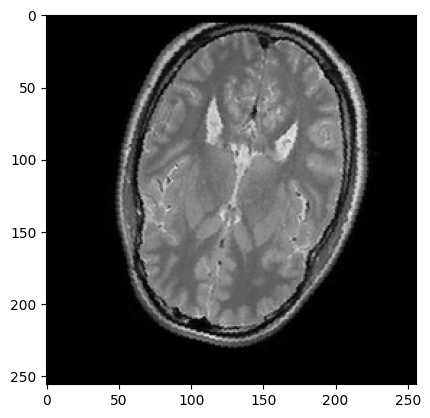

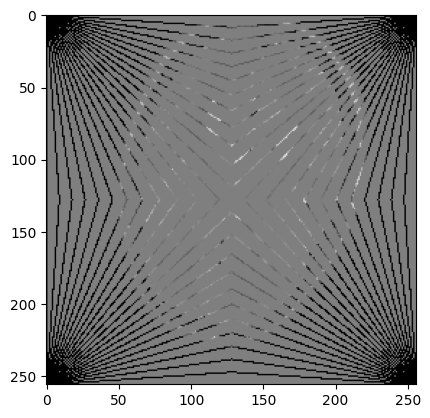

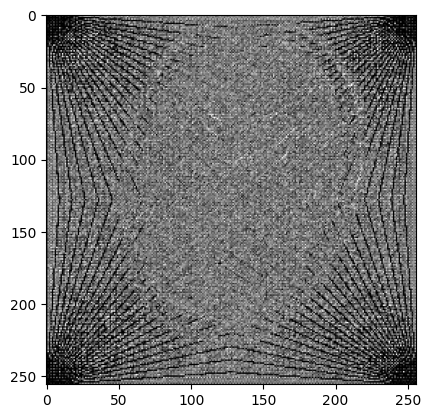

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 7.42 G_loss_img_epoch: 63.18 G_loss_freq_epoch: 0.82
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 13.25 G_loss_img_epoch: 62.37 G_loss_freq_epoch: 0.82
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 20.76 G_loss_img_epoch: 61.55 G_loss_freq_epoch: 0.83
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 29.91 G_loss_img_epoch: 60.74 G_loss_freq_epoch: 0.83
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_ep

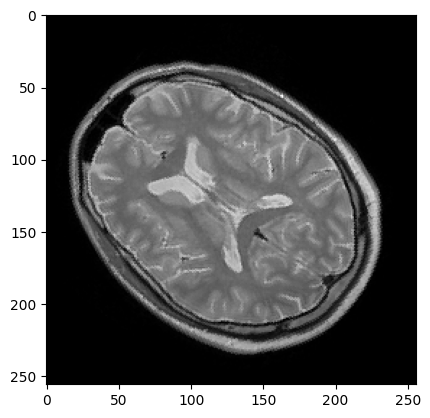

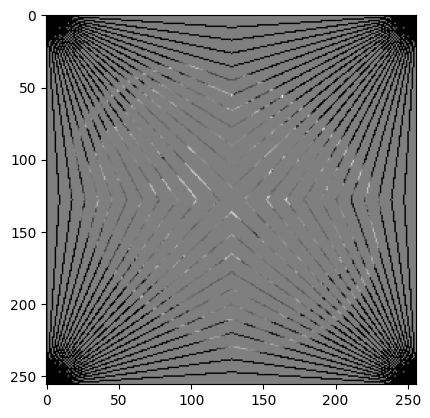

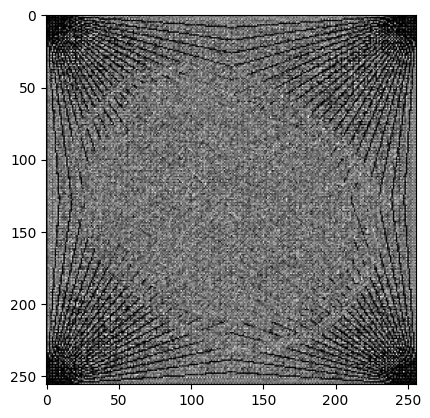

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 50.41 G_loss_img_epoch: 59.06 G_loss_freq_epoch: 0.83
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 61.21 G_loss_img_epoch: 58.22 G_loss_freq_epoch: 0.84
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 72.22 G_loss_img_epoch: 57.42 G_loss_freq_epoch: 0.84
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
G_loss_adv_epoch: 83.0 G_loss_img_epoch: 56.61 G_loss_freq_epoch: 0.85


In [ ]:
"Wasserstein Loss Training"
image_recon=[]
loss_arr=[]
print(device)
for epoch in range(epochs):
  for batch_idx, im_tuple in enumerate(dataloader, 0):

    full_image_batch = im_tuple[0]
    # print(device)
    full_image_batch = full_image_batch.to(device)
    print(full_image_batch.dtype)
    # us_kspace_batch = im_tuple[1]
    us_kspace_batch = us_kspace_batch.to(device)
    zf_recon_batch = im_tuple[2]
    zf_recon_batch = zf_recon_batch.to(device)


    # recon_image_batch = netG(torch.ifft(mask*torch.fft(full_image_batch.permute([0,2,3,1]),2)).permute([0,3,1,2]))[1]
    # recon_kspace_batch = (mask*torch.fft(netG(torch.ifft(us_kspace_batch.permute([0,2,3,1]),2).permute([0,3,1,2]))[1].permute([0,2,3,1]),2)).permute([0,3,1,2])
    # recon_image_batch = netG(FhRh(RF(full_image_batch, batch_mask, batch = True), batch = True))[0]
    # recon_kspace_batch = RF(netG(FhRh(us_kspace_batch, batch=True))[0], batch_mask, batch = True)


    #Discriminator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    for _ in range(5):
      opt_D.zero_grad()#Different mini batches for real and fake targets

      real_logits = netD(full_image_batch).view(-1)
      real_d_loss = -1*torch.mean(real_logits)
      D_loss_real.append(real_d_loss)
      real_d_loss.backward()

      gen_full_image_batch = netG(zf_recon_batch)[1]
      fake_logitsD = netD(gen_full_image_batch.detach()).view(-1)
      fake_d_loss = torch.mean(fake_logitsD)
      D_loss_fake.append(fake_d_loss)
      fake_d_loss.backward()

      # with torch.no_grad():
      d_loss_total = real_d_loss+fake_d_loss
      D_loss_total.append(d_loss_total.data)

      opt_D.step()

      for p in netD.parameters():
        p.data.clamp_(-0.02, 0.02)

    #Generator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_G.zero_grad()

    fake_logitsG = netD(gen_full_image_batch).view(-1)
    adv_g_loss = -1*torch.mean(fake_logitsG)
    G_loss_adv.append(adv_g_loss)
    adv_g_loss.backward()

    recon_image_batch = netG(zf_recon_batch)[1] #Because same underlying image
    g_image_loss = gamma*criterionG_image(recon_image_batch,full_image_batch)
    G_loss_img.append(g_image_loss)
    g_image_loss.backward()

    recon_kspace_batch = RF(netG(zf_recon_batch)[1], batch_mask, batch = True) #Because same underlying image
    g_freq_loss = alpha*criterionG_freq(recon_kspace_batch,us_kspace_batch)
    G_loss_freq.append(g_freq_loss)
    g_freq_loss.backward()

    # with torch.no_grad():
    g_loss_total = adv_g_loss#+g_image_loss#+g_freq_loss
    G_loss_total.append(g_loss_total)

    opt_G.step()

  # print("Epoch:", epoch, "G Loss:", float('%.2f' % g_loss_total.data.tolist()), "D Loss:", float('%.2f' % d_loss_total.data.tolist()))

  # if epoch%25==0:
  #   clear_output(wait=True)
  G_loss_adv_epoch = sum(G_loss_adv[-batch_size:])
  G_loss_img_epoch = sum(G_loss_img[-batch_size:])
  G_loss_freq_epoch = sum(G_loss_freq[-batch_size:])
  print("G_loss_adv_epoch:", float('%.2f' % G_loss_adv_epoch.data.tolist()), "G_loss_img_epoch:", float('%.2f' % G_loss_img_epoch.data.tolist()), "G_loss_freq_epoch:", float('%.2f' % G_loss_freq_epoch.data.tolist()))

  if epoch%5==0:
    disp_img = gen_full_image_batch[0].cpu().detach().numpy()
    disp_img = np.clip(disp_img, -1, 1)
    disp_img2 = full_image_batch[0].cpu().detach().numpy()
    disp_img3 = zf_recon_batch[0].cpu().detach().numpy()

    displayTensor(disp_img2)
    plt.show()
    displayTensor(disp_img3)
    plt.show()
    displayTensor(disp_img)
    plt.show()
    # print(recon_image_batch.size())

  image_recon.append(disp_img)
  # loss_arr.append(g_image_loss)

Without clamping

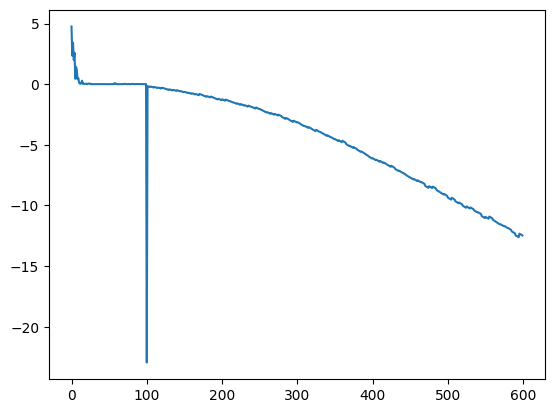

In [ ]:
# Assuming D_loss_total is a list of CUDA tensors
D_loss_total_cpu = [loss.item() for loss in D_loss_total]  # Convert each tensor to a NumPy array

plt.plot(D_loss_total_cpu)
plt.show()

With clamping

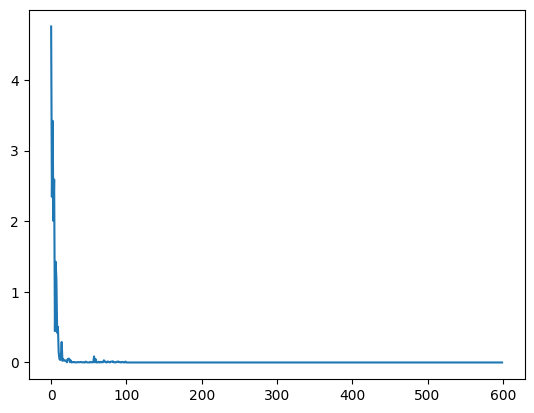

In [ ]:
# Assuming D_loss_total is a list of CUDA tensors
# Clamp values to min 0.0
D_loss_total_cpu = [max(0.0, loss.item()) for loss in D_loss_total]  # Convert each tensor to a NumPy array

plt.plot(D_loss_total_cpu)
plt.show()

In [ ]:
#original graph and plot
# plt.plot(D_loss_total)

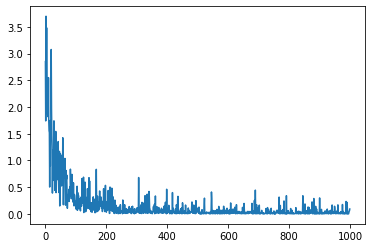

In [ ]:
np.max(disp_img)
disp_img = np.clip(disp_img, -1, 1)

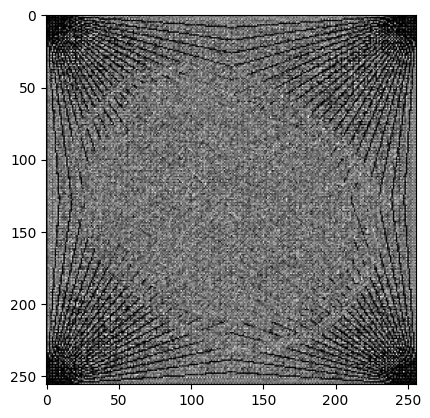

In [ ]:
displayTensor(disp_img)
plt.show()